<a href="https://colab.research.google.com/github/mireillejb/ML-Practice/blob/main/CNN_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Dependencies and Setup

In [2]:
!pip install tensorflow opencv-python matplotlib

In [1]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.9.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.14
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.22.0
astropy                               7.1.0
astropy

In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [7]:
import cv2
import imghdr

/tmp/ipython-input-4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [8]:
from google.colab import files
uploaded = files.upload()


Saving data.zip to data.zip


In [9]:
import zipfile
import os

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# Now your data is in ./data/

In [10]:
data_dir = 'data'

In [11]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [12]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [14]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [15]:
data_iterator = data.as_numpy_iterator()

In [16]:
batch = data_iterator.next()

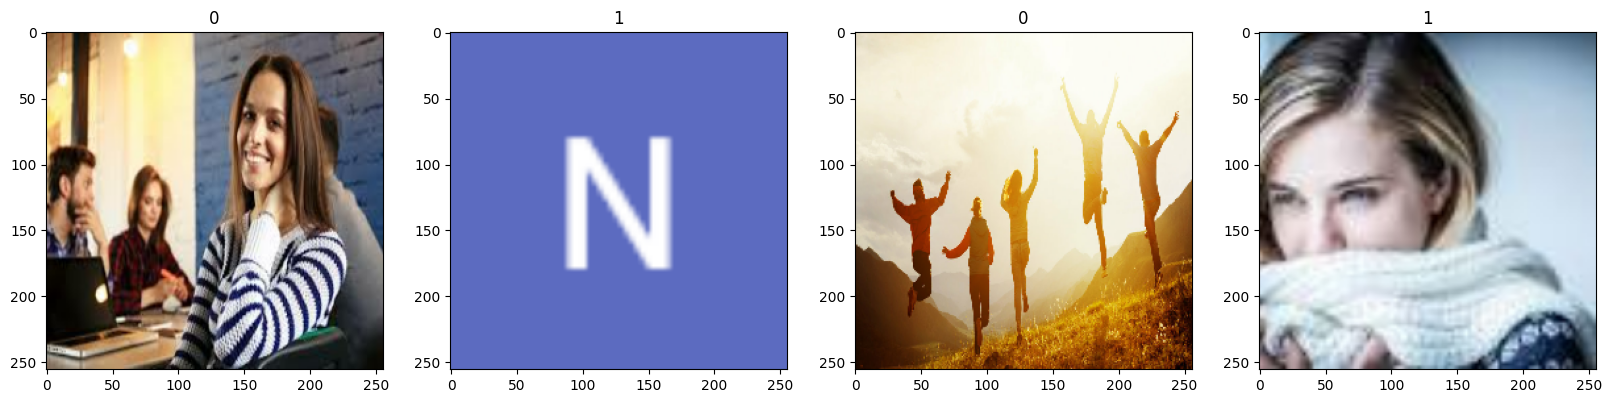

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [20]:
data = data.map(lambda x,y: (x/255, y))

In [21]:
data.as_numpy_iterator().next()

(array([[[[0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          ...,
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          ...,
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          ...,
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157]],
 
         ...,
 
         [[0.00392157, 0.00392157, 0.00392157],
          [0.00392

# 5. Split Data

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [23]:
train_size

7

In [24]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [25]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 495ms/step - accuracy: 0.5017 - loss: 0.6933 - val_accuracy: 0.5469 - val_loss: 0.6886
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 606ms/step - accuracy: 0.3615 - loss: 0.7021 - val_accuracy: 0.4688 - val_loss: 0.6934
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 685ms/step - accuracy: 0.5208 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 598ms/step - accuracy: 0.5597 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5295 - loss: 0.6920 - val_accuracy: 0.5781 - val_loss: 0.6884
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - accuracy: 0.5015 - loss: 0.6926 - val_accuracy: 0.4844 - val_loss: 0.6927
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 651ms/step - accuracy: 0.5843 - loss: 0.6910 - val_accuracy: 0.5938 - val_loss: 0.6911
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 756ms/step - accuracy: 0.6314 - loss: 0.6905 - val_accuracy: 0.6562 - val_loss: 0

# 8. Plot Performance

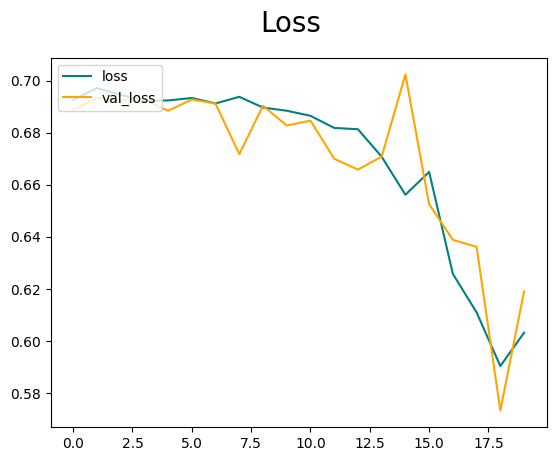

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

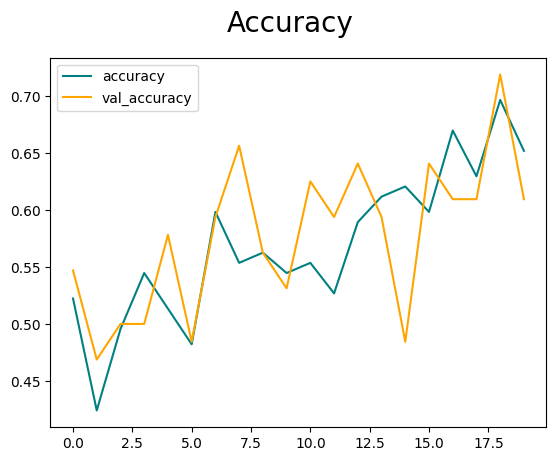

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [36]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [38]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


In [39]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.8333333, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9411765, shape=(), dtype=float32)


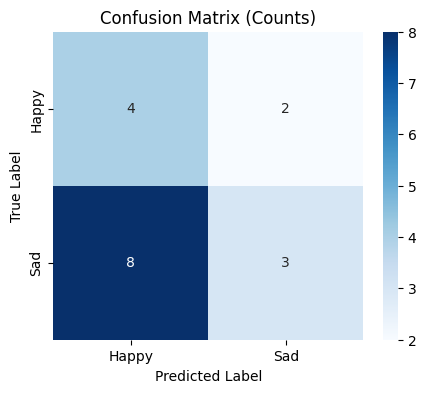

In [50]:
# Counts confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Happy', 'Sad'],
            yticklabels=['Happy', 'Sad'])
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 10. Test

In [51]:
import cv2

In [52]:
from google.colab import files
uploaded = files.upload()


Saving 8iAb9k4aT.jpg to 8iAb9k4aT.jpg
Saving 154006829.jpg to 154006829.jpg


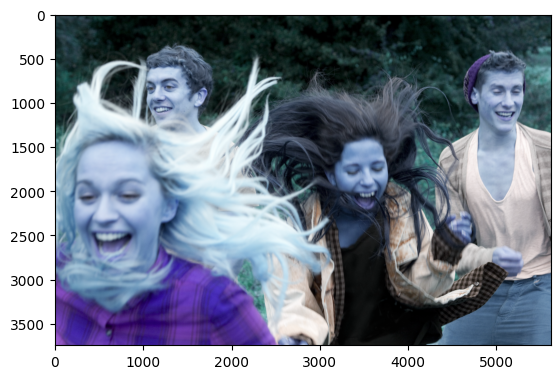

In [53]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

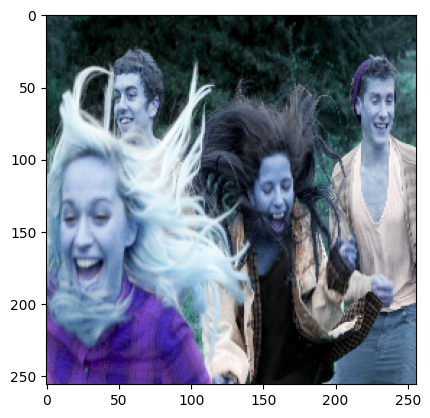

In [54]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [55]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


In [57]:
yhat

array([[8.188725e-19]], dtype=float32)

In [58]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
